<h1 style="color:red" align="center">Neural Networks: The basics made for all</h1>
<p align="center">By Bastien Lhopitallier and Robin Sobczyk</p>

<h2 style="color:green" align="center">Course 3: Technical limits of AI</h2>

Here are the topics we will cover in this course:
- explainability of a neural network model
- trust in its results and capacity to correctly solve its task
- how to realise a basic analysis of the activations of a network with heatmaps
- what are the risks of neural networks with malicious sample optimisation (GANs ?)
- proxy values = charbel piece droite

In [1]:
# Imports for the code
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

<h3 style="color:skyblue">Explainability</h3>

NN = black boxes, not much can be done about explainability

<h3 style="color:skyblue">Study of a network through its activations</h3>

We will now study how to analyse the activations of a convolutional neural network and plot them with heatmaps. The goal is to get insights on which "zones" of an input image are used to make the prediction. The method used is called [Grad-CAM](https://doi.org/10.48550/arXiv.1610.02391) and the CNN that we will study here is a pre-trained ResNet34 model (which means that no training will be done here).

Let's load it with the next cell.

In [2]:
resnet34 = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

Because no training will be done, we can set the model in evaluation mode, which will disable all gradient computations to gain time (doing this also displays the structure of our model):

In [3]:
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The goal here is to get the outputs of the model before the softmax operation to use them. We can see that there is no softmax at the end of this specific model, so we can just fetch the outputs without needing other operations. Moreover, the output will be a vector of values of size 1000, which means that this model is made to do image classificaiton between 1000 different classes.

The next cells downloads a dictionnary containing the names of each class:

In [4]:
class_names = pickle.load(
    urllib.request.urlopen(
        "https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl"
    )
)
print(class_names)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

Here is a function to preprocess the images in order to use them with `resnet34`:

In [16]:
def preprocess_images_in_folder(path):
    dataset = datasets.ImageFolder(
        path,
        transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # Extract a 224x224 subimage
                transforms.ToTensor(),  # Convert to tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalise the tensor
            ]
        ),
    )

    return dataset

Let's apply this preprocessing to images from the [ImageNET](https://www.image-net.org/index.php) dataset:

In [21]:
dataset = preprocess_images_in_folder("materials")

We can show an image from the dataset, along with its preprocessed version (feel free to change the index of the chosen picture):

Original image:


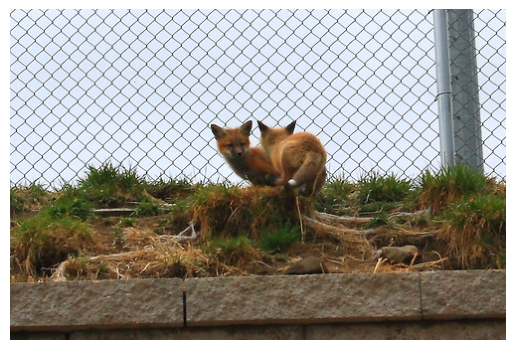

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preprocessed version:


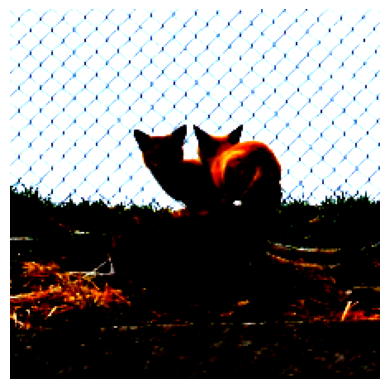

In [44]:
index = 0  # Change this to try out the different images

input_image = Image.open(dataset.imgs[index][0]).convert("RGB")
print("Original image:")
plt.axis("off")
plt.imshow(input_image)
_ = plt.show()
print("Preprocessed version:")
plt.axis("off")
_ = plt.imshow(dataset[index][0].permute(1, 2, 0))

and the result when passed through our network (we print the first 5 guesses):

In [19]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
scores, indices = torch.topk(output, 5)
scores, indices = scores[0].detach().numpy(), indices[0].numpy()
for i in range(5):
    print(
        f"Top {i+1} ({scores[i]:.2f}): {class_names[indices[i]]} (class n°{indices[i]})"
    )

Top 1 (16.11): red wolf, maned wolf, Canis rufus, Canis niger (class n°271)
Top 2 (15.06): kit fox, Vulpes macrotis (class n°278)
Top 3 (14.78): red fox, Vulpes vulpes (class n°277)
Top 4 (13.49): dhole, Cuon alpinus (class n°274)
Top 5 (12.52): Shetland sheepdog, Shetland sheep dog, Shetland (class n°230)


We'll also need the cropped but unnormalized versions of the images to show the Grad-CAM outputs:

In [49]:
unnormalized_dataset = datasets.ImageFolder(
    "materials",
    transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # same transforms, just without the Normalize
        ]
    ),
)

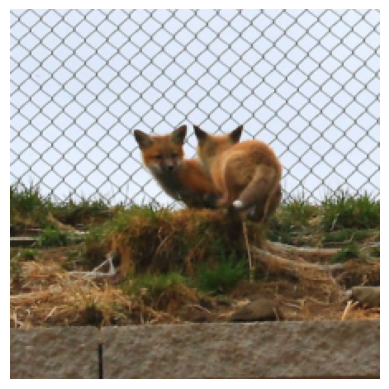

In [52]:
plt.axis("off")
_ = plt.imshow(unnormalized_dataset[index][0].permute(1, 2, 0))

Now let's explain the process of Grad-CAM. We'll take an image and a class name, then pass the image through the model (so that we would be ready for the backpropagation step if we were training the model). Then,  we set all gradients to 0 except for the chosen class for which we set it to 1.

After that, we backpropagate these values, and extract the backpropagated gradients at the layer(s) where we want to plot the heatmap(s).

However, extracting gradients requires additional operations. Indeed, the tensors that contain them can't be accessed normally. We need to make use of [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)! Hooks are functions that can be registered on a torch Module (the base class for all neural network modules) or a torch Tensor. They can either be a forward hook or a backward hook. The forward hook will be activated during the forward pass, and the same goes for the backward hooks with the backpropagation step.

To successfully apply Grad-CAM, we need to get access to the output (during the forward pass) and the gradient output (during the backward pass) of the chosen module. We'll also plot the outputs for the top 3 predictions of the image.

In [53]:
def Grad_CAM(dataset, img_index, module_to_hook):
    # Dictionnary to save the hook results
    hook_results = {}

    # Make a figure to plot the results
    _, axs = plt.subplots(1, 4, figsize=(20, 6))
    # Print original image
    un_img = unnormalized_dataset[img_index][0].permute(1, 2, 0)
    axs[0].imshow(un_img)
    axs[0].set_title(f"Cropped original image {img_index}")

    # Hook definitions

    # === YOUR CODE ===

    def forward_hook(_, __, output):
        # Register the output
        hook_results["forward"] = output

    def backward_hook(_, __, grad_outputs):
        # Register the gradient output
        hook_results["backward"] = grad_outputs[0]

    # =================

    # Register the hooks
    forward_handle = module_to_hook.register_forward_hook(forward_hook)
    backward_handle = module_to_hook.register_backward_hook(backward_hook)

    # Get the raw class scores and top 3 possible labels

    # === YOUR CODE ===
    img = dataset[img_index][0].view(1, 3, 224, 224)
    raw_class_scores = resnet34(img)
    _, top_indices = torch.topk(raw_class_scores, 3)
    # =================

    # Do Grad-CAM for each of the top 3 predictions
    for i, top_idx in enumerate(top_indices[0]):

        # Set all gradients to 0

        # === YOUR CODE ===
        resnet34.zero_grad()
        # =================

        # Backpropagate just on the top index

        # === YOUR CODE ===
        top_class = raw_class_scores[0, top_idx]
        # =================

        # As it is not a leaf of the backpropagation graph, we use
        # retain_graph=True to avoid the gradient being destroyed
        top_class.backward(retain_graph=True)

        # Retrieve the hook outputs
        forw, back = (
            hook_results["forward"].squeeze(),
            hook_results["backward"].squeeze(),
        )

        # Implementation of the equations (1) and (2) from the Grad-CAM paper
        # (cited at the beggining of this part)

        # === YOUR CODE ===
        # Equation (1) of the paper
        neuron_importance_weights = torch.mean(back, dim=(1, 2))
        # Equation (2) of the paper (Hint: use torch.einsum)
        grad_cam = torch.einsum("c,chw->hw", neuron_importance_weights, forw)
        grad_cam = torch.relu(grad_cam)
        # =================

        # Upscale the result, as it is a 7x7 heatmap
        grad_cam = F.interpolate(
            grad_cam[None, None, ...], size=(224, 224), mode="bilinear"
        ).squeeze()
        # Normalize the result
        mini, maxi = torch.min(grad_cam), torch.max(grad_cam)
        grad_cam = (grad_cam - mini) / (maxi - mini)

        # Plot original cropped image and heatmap
        axs[i + 1].imshow(un_img)
        axs[i + 1].imshow(grad_cam.detach().numpy(), cmap="jet", alpha=0.5)
        class_name = class_names[int(top_idx)].split(",")[0]
        axs[i + 1].set_title(class_name)

    # Remove the hooks
    forward_handle.remove()
    backward_handle.remove()
    plt.show()

/home/machiavelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


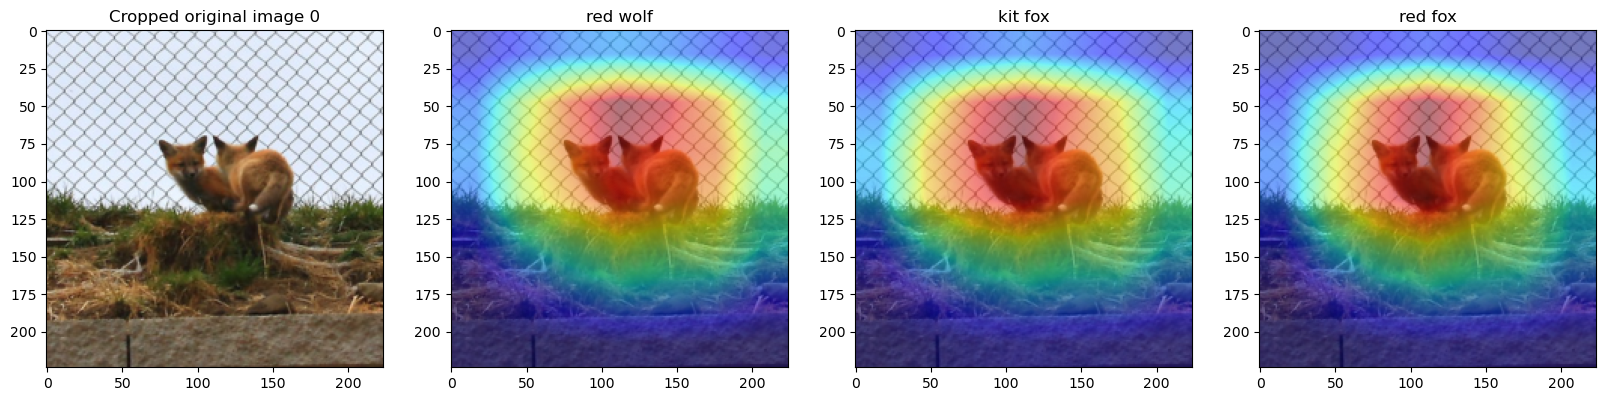

In [55]:
for i in range(len(dataset)):
    Grad_CAM(dataset, i, resnet34.layer4[2].conv2)

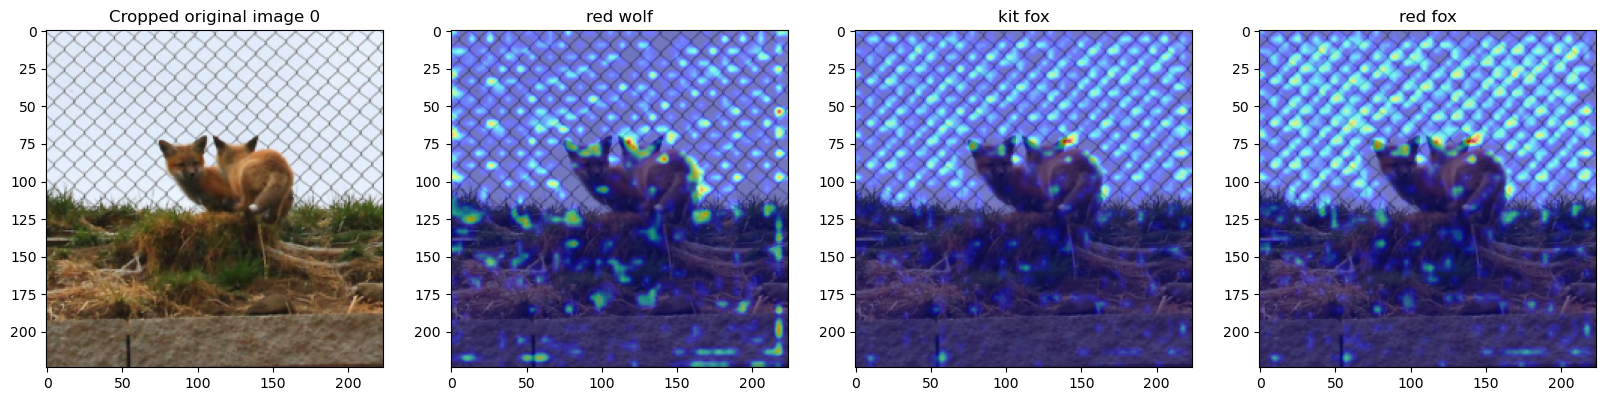

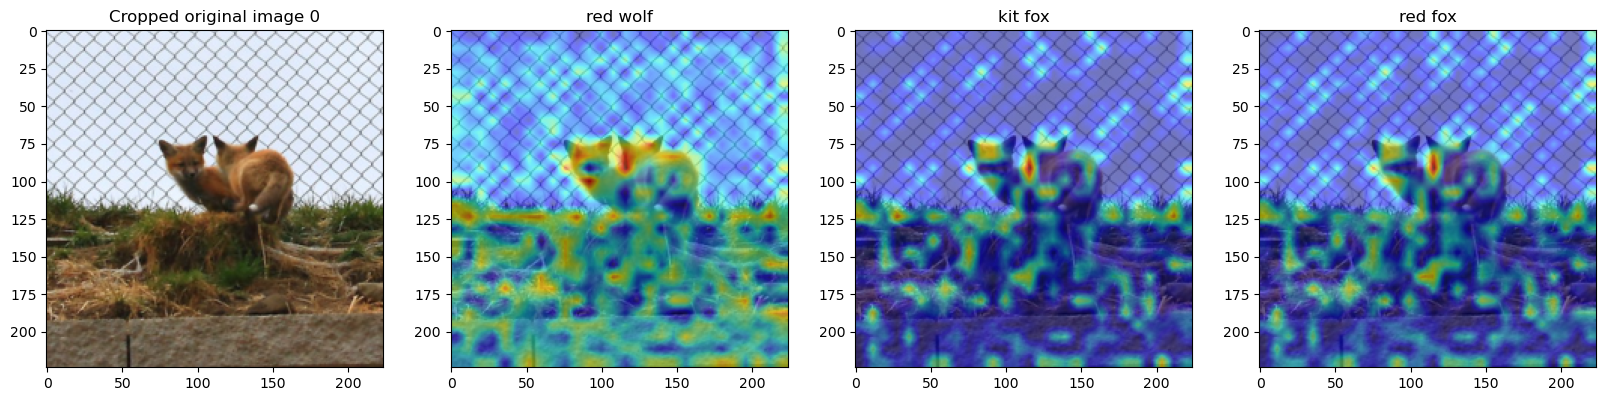

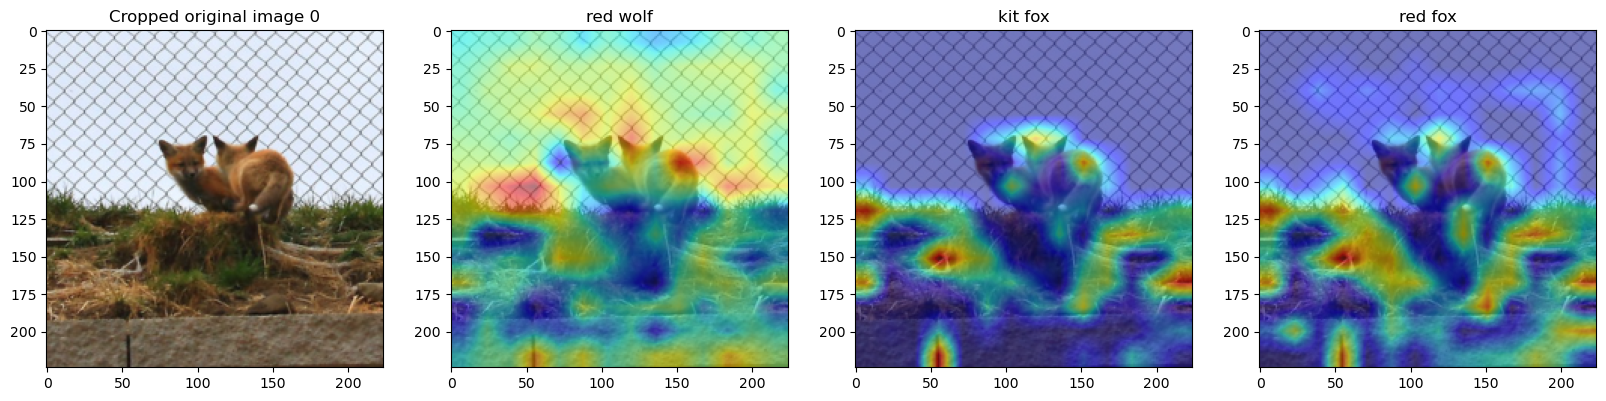

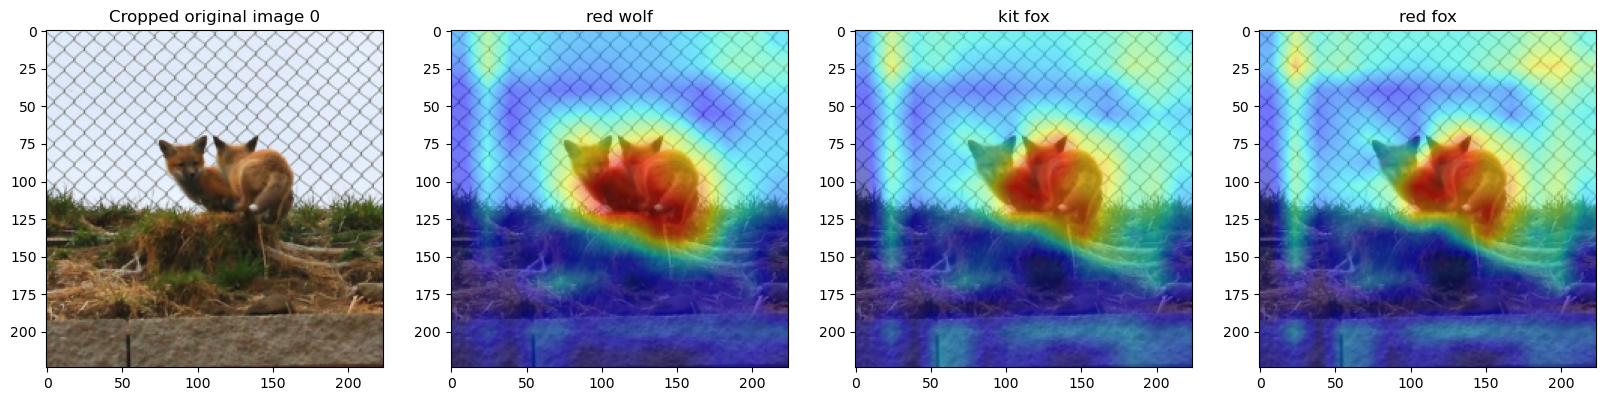

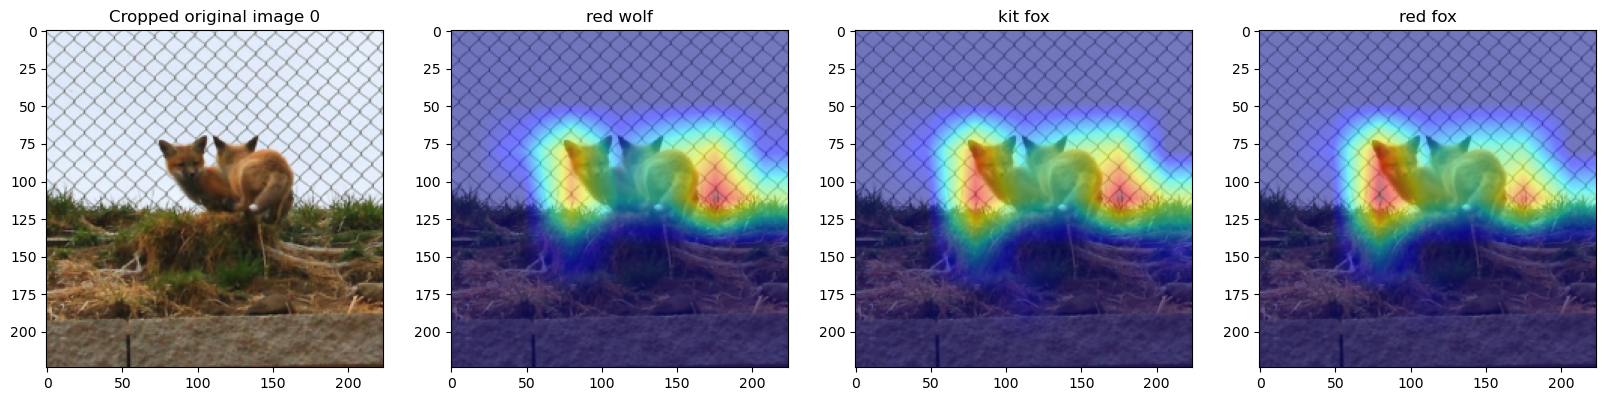

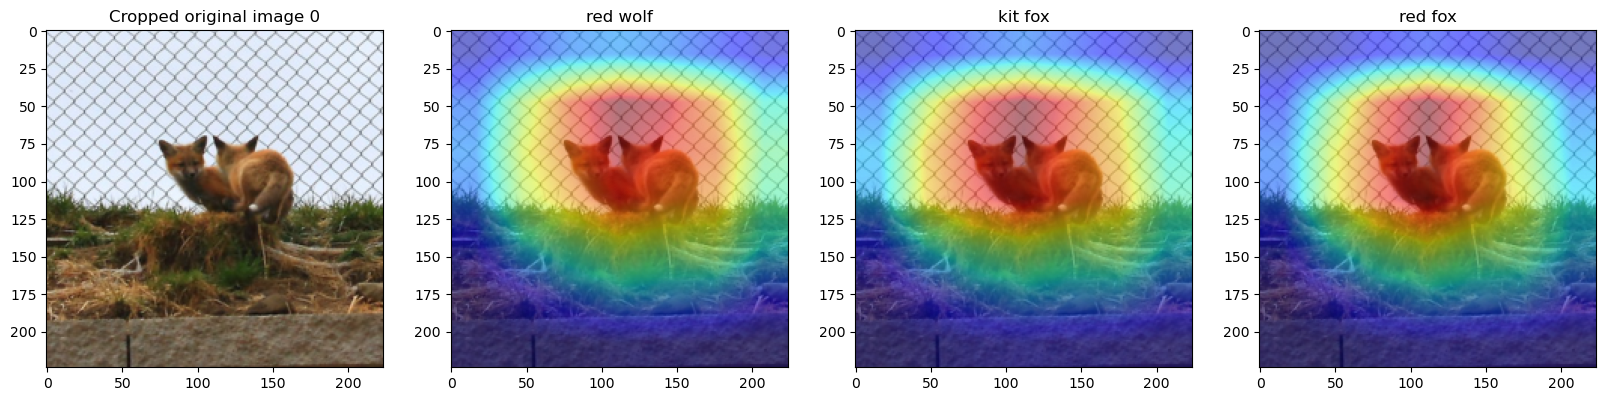

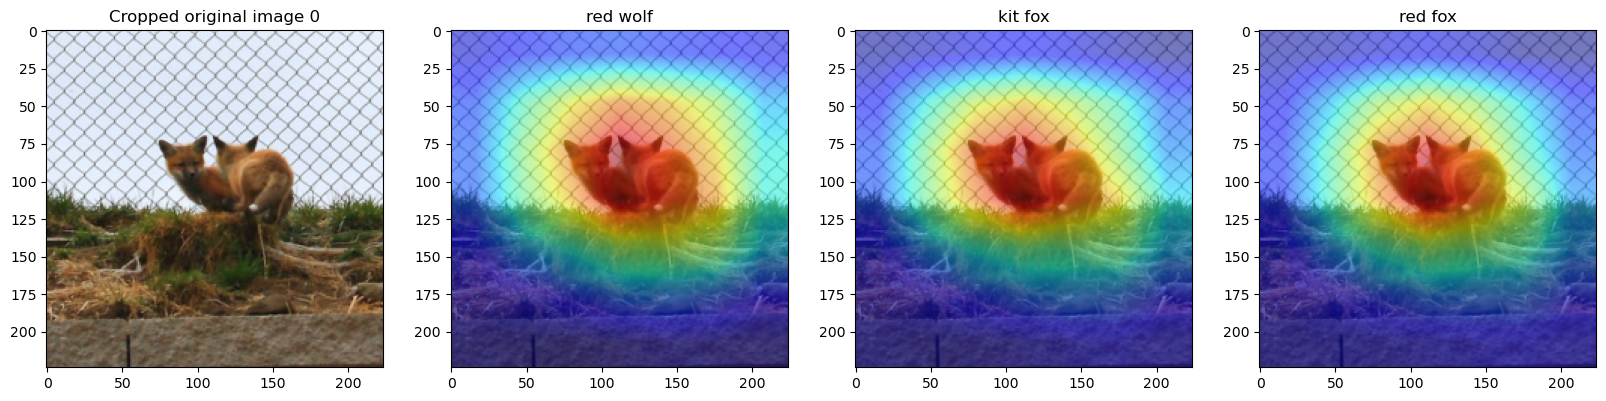

In [58]:
layer_list = [
    resnet34.layer1[2].conv2,
    resnet34.layer2[0].conv1,
    resnet34.layer3[0].conv1,
    resnet34.layer3[5].conv1,
    resnet34.layer4[1].conv2,
    resnet34.layer4[2].conv2,
    resnet34.layer4[2].bn2,
]

for layer in layer_list:
    Grad_CAM(dataset, 0, layer)